In [1]:
!pip install pingouin
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pingouin as pg

# Load the data
base_data = np.load('csg_strain_5000.npy')
base_params = np.load('csg_param_5000.npy')

print("Original data shape:", base_data.shape)    # Expected: (3000, 3, 1024)
print("Original params shape:", base_params.shape)

def augment_signal(signal, noise_level=0.005, shift_max=10):
    # Add random noise
    noisy_signal = signal + noise_level * np.random.randn(*signal.shape)

    # Randomly choose a shift value between -shift_max and shift_max
    shift = np.random.randint(-shift_max, shift_max)

    if shift > 0:
        # Pad on the left and remove values from the right
        augmented_signal = np.pad(noisy_signal, ((0, 0), (shift, 0)), mode='constant')[:, :-shift]
    elif shift < 0:
        # Pad on the right and remove values from the left
        augmented_signal = np.pad(noisy_signal, ((0, 0), (0, -shift)), mode='constant')[:, -shift:]
    else:
        augmented_signal = noisy_signal

    return augmented_signal

# Pre-generate the augmented dataset
augmented_data = []
augmented_params = []

num_augmentations = 0  # Number of augmented versions per original sample

for sample, param in zip(base_data, base_params):
    # Add the original sample
    augmented_data.append(sample)
    augmented_params.append(param)

    # Generate additional augmented samples
    for _ in range(num_augmentations):
        aug_sample = augment_signal(sample)
        augmented_data.append(aug_sample)
        augmented_params.append(param)

# Convert lists to NumPy arrays
data = np.array(augmented_data)
params = np.array(augmented_params)

print("Augmented data shape:", data.shape)
print("Augmented params shape:", params.shape)

gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

  Obtaining dependency information for pingouin from https://files.pythonhosted.org/packages/eb/56/6d3607f3a78aee1de8e5466f5171722c8e344266a12dc44ccb73d024b3b3/pingouin-0.5.5-py3-none-any.whl.metadata
  Obtaining dependency information for pandas>=1.5 from https://files.pythonhosted.org/packages/cd/5f/4dba1d39bb9c38d574a9a22548c540177f78ea47b32f99c0ff2ec499fac5/pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for pandas-flavor from https://files.pythonhosted.org/packages/67/1a/bfb5574b215f530c7ac5be684f33d60b299abbebd763c203aa31755f2fb2/pandas_flavor-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=1.2 from https://files.pythonhosted.org/packages/a8/f3/62fc9a5a659bb58a03cdd7e258956a5824bdc9b4bb3c5d932f55880be569/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata

2025-02-24 20:11:50.314890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 20:11:50.314927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 20:11:50.315693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 20:11:50.390558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Original data shape: (5000, 3, 1024)
Original params shape: (5000, 5)
Augmented data shape: (5000, 3, 1024)
Augmented params shape: (5000, 5)
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-02-24 20:11:52.650651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-24 20:11:52.667612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-24 20:11:52.670328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import pingouin as pg

# Generate a pearsons correlation statistic between each detector
corr_stats = []

for sample in data:
    # Generate statistics and add as an array to the corr_stats array
    stat1 = pg.corr(sample[0], sample[1]) # Detector 1 and 2
    stat2 = pg.corr(sample[0], sample[2]) # Detector 1 and 3
    stat3 = pg.corr(sample[1], sample[2]) # Detector 2 and 3
    corr_stats.append([stat1.r, stat2.r, stat3.r])

corr_stats = np.array(corr_stats)
print("Correlation stats shape:", corr_stats.shape)

Correlation stats shape: (5000, 3, 1)


0.5925223481110858
219.71772176152746
73.0
0.0224609375
141.0


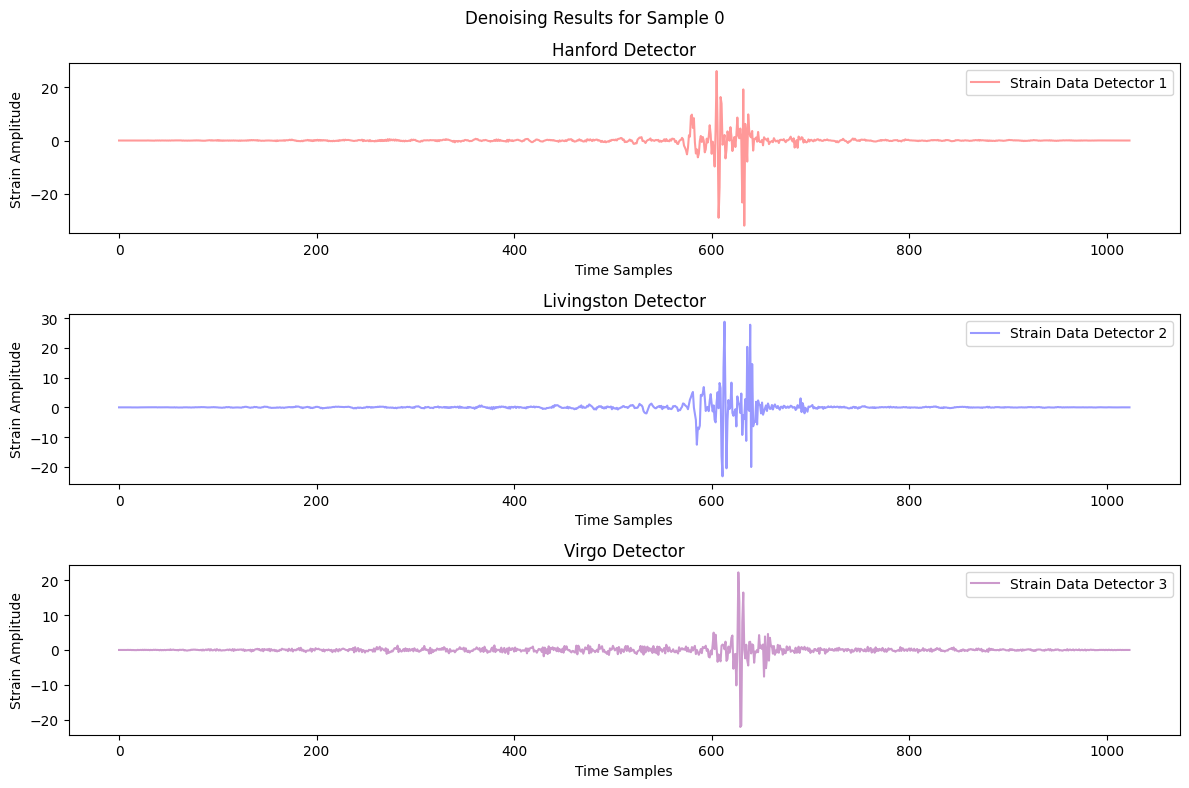

In [3]:
time = np.linspace(0, 1024, 1024)

sample_idx = 0

fig, axs = plt.subplots(3, 1, figsize=(12, 8))
detectors = ['Hanford', 'Livingston', 'Virgo']
col = ["red", "blue", "purple"]
for d in range(3):
    # Window the data to denoise a bit
    window = np.bartlett(data[sample_idx][d].size)
    x_windowed = data[sample_idx][d]*window
    axs[d].plot(x_windowed, color = f"{col[d]}", label=f'Strain Data Detector {d+1}', alpha=0.4)
    axs[d].legend()
    axs[d].set_title(f'{detectors[d]} Detector')
    axs[d].set_xlabel("Time Samples")
    axs[d].set_ylabel("Strain Amplitude")

print(params[sample_idx][0])
print(params[sample_idx][1])
print(params[sample_idx][2])
print(params[sample_idx][3])
print(params[sample_idx][4])
plt.suptitle(f"Denoising Results for Sample {sample_idx}")
plt.tight_layout()
plt.show()

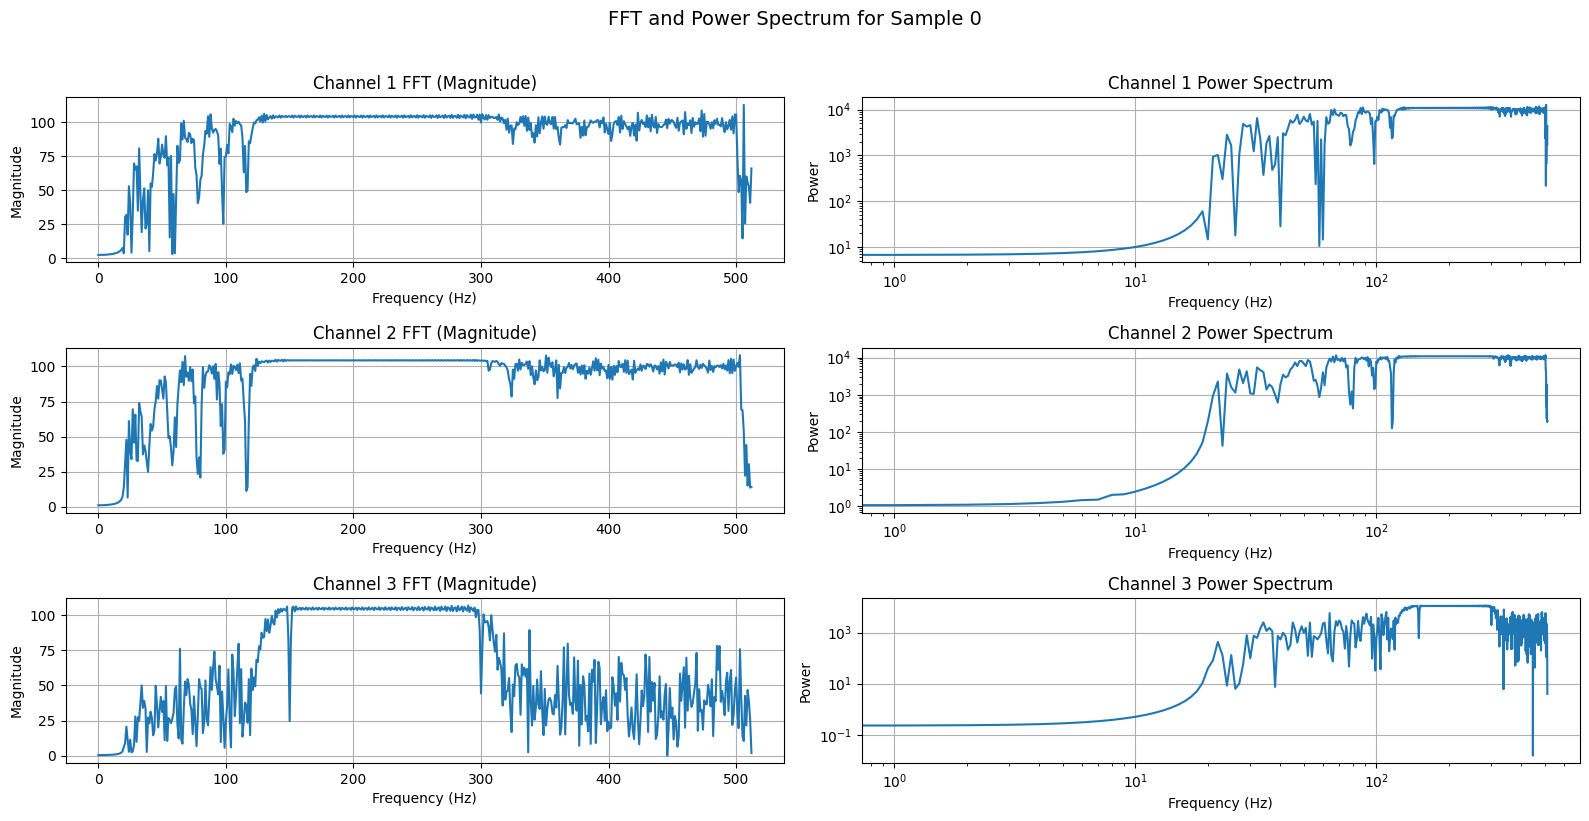

In [4]:
# Function to compute and plot FFT and power spectrum for a given sample index
def plot_fft_and_power_spectrum(data, sample_index=0):
    sample = data[sample_index]

    # Create frequency axis
    num_steps = sample.shape[1]
    sampling_rate = 1024
    frequencies = np.fft.rfftfreq(num_steps, d=1./sampling_rate)

    fig, axes = plt.subplots(3, 2, figsize=(16, 8))
    fig.suptitle(f"FFT and Power Spectrum for Sample {sample_index}", fontsize=14, y=1.02)

    # Iterate through each channel and compute FFT
    for i in range(3):
        channel_data = sample[i]

        # Compute FFT and power spectrum
        fft_values = np.fft.rfft(channel_data)
        power_spectrum = np.abs(fft_values) ** 2

        # Plot FFT (magnitude)
        axes[i, 0].plot(frequencies, np.abs(fft_values))
        axes[i, 0].set_title(f"Channel {i + 1} FFT (Magnitude)")
        axes[i, 0].set_xlabel("Frequency (Hz)")
        axes[i, 0].set_ylabel("Magnitude")
        axes[i, 0].grid(True)

        # Plot Power Spectrum
        axes[i, 1].loglog(frequencies, power_spectrum)
        axes[i, 1].set_title(f"Channel {i + 1} Power Spectrum")
        axes[i, 1].set_xlabel("Frequency (Hz)")
        axes[i, 1].set_ylabel("Power")
        axes[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_fft_and_power_spectrum(data, sample_index=0)

There are 4 different models at the moment:

- CNN with standard transformer encoder block.It uses a standard transformer design that combines several important components: multi-head self-attention, shortcuts between layers, and a feed-forward network. With multiple attention heads, the model can recognize different kinds of relationships and patterns in the features it gets from the CNN at the same time. The shortcuts and layer adjustments help make the training smoother, making sure the original CNN features and the new attention-based features work well together.

- CNN with positional encoding. The regular transformer block includes specific information about the position of the input data. Because self-attention methods don't automatically recognize the order of the data, adding positional information helps keep the sequence intact.

- CNN with a simplified, single head attention block. This makes transformer block simpler by using just one attention head, but it increases the size of the key to ensure the model can still understand important details. Fewer attention heads mean the model is less complicated and has fewer parts, which is helpful when there's not a lot of training data or when we want to avoid overfitting.

- And a standard ResNET model to compare against. In many survey papers, ResNET models have been found to be the best for time series analysis.

UPDATE:

Now the models are

- Standard CNN for a baseline

- Ensemble model of a CNN

- Ensemble model of a CNN + Single head attention block as it was the most performant

- ResNET50 Deep CNN

The models also take in correlation data between the detectors (Pearsons).

In [5]:
# Project features to transformer dimension
def build_transformer_input(x_weighted, units=256):
    return layers.Dense(units, activation='relu')(x_weighted)

# Transformer Block: (Single-Head)
def transformer_block(x, key_dim=256, ff_dim=256, dropout_rate=0.1):
    x_norm = layers.LayerNormalization()(x)
    
    attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=key_dim, dropout=dropout_rate)(x_norm, x_norm)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    x = layers.Add()([x_norm, attn_output])  # Residual connection with normalized x

    x_norm = layers.LayerNormalization()(x)
    ffn_output = layers.Dense(ff_dim, activation='relu')(x_norm)
    ffn_output = layers.Dense(x.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    x = layers.Add()([x, ffn_output])
    return x


# Weighted Loss Function
def weighted_mse(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Compute the squared errors
        error = tf.square(y_true - y_pred)

        # Multiply each error by its corresponding weight
        weighted_error = error * weights

        # Return the mean over all outputs and samples
        return tf.reduce_mean(weighted_error)

    return loss

In [6]:
# Define loss functions for each output (using MSE here)
losses = {
    'param1': 'mse', # Central time
    'param2': 'mse', # Central Frequency
    'param3': 'mse', # Bandwidth
    'param4': 'mse', # Duration
    'param5': 'mse'  # SNR
}

# Define loss weights for each output
loss_weights = {
    'param1': 1.0,
    'param2': 1.0,
    'param3': 1.0,
    'param4': 1.0,
    'param5': 1.0
}

In [7]:
# Data preprocessing
# Transpose X to match Keras Conv1D expected input shape: (samples, time steps, channels)
X = np.transpose(data, (0, 2, 1))

# Perform a 70-30 split for training and temporary set
X_train, X_temp, y_train, y_temp, corr_train, corr_temp = train_test_split(
    X, params, corr_stats, test_size=0.3, random_state=42
)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test, corr_val, corr_test = train_test_split(
    X_temp, y_temp, corr_temp, test_size=1/3, random_state=42
)

# Scale the target parameters
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled   = scaler.transform(y_val)
y_test_scaled  = scaler.transform(y_test)

In [8]:
# Baseline raw CNN used as a baseline

# Branch 1: Gravitational Wave Data (shape: (1024, 3))
wave_input = keras.Input(shape=(1024, 3), name='wave_input')

# CNN Front-End
x = layers.Conv1D(36, kernel_size=7, activation='relu')(wave_input)

# ResNet Block 1
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 2
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 3
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# Class Activation Map (CAM) preserving the temporal dimension
cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
x_weighted = layers.Multiply()([x, cam_output])
x_pooled = layers.GlobalAveragePooling1D()(x_weighted)

# Fully Connected Layers for the waveform branch
x_fc = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4))(x_pooled)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4))(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4))(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)

# Branch 2: Correlation Statistics (shape: (3,))
corr_input = keras.Input(shape=(3,), name='corr_input')
y = layers.Flatten()(corr_input)
y = layers.Dense(16, activation='relu')(corr_input)
y = layers.Dense(16, activation='relu')(y)

# Merge the two branches
merged = layers.Concatenate()([x_fc, y])
z = layers.Dense(32, activation='relu')(merged)

# 5 Separate Outputs for Regression
output1 = layers.Dense(1, activation='linear', name='param1')(z)
output2 = layers.Dense(1, activation='linear', name='param2')(z)
output3 = layers.Dense(1, activation='linear', name='param3')(z)
output4 = layers.Dense(1, activation='linear', name='param4')(z)
output5 = layers.Dense(1, activation='linear', name='param5')(z)

# Define the model using the two inputs
model_v1 = keras.Model(inputs=[wave_input, corr_input],
                       outputs=[output1, output2, output3, output4, output5])

# Compile the Model
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model_v1.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'param1': ['mae', 'R2Score'],
        'param2': ['mae', 'R2Score'],
        'param3': ['mae', 'R2Score'],
        'param4': ['mae', 'R2Score'],
        'param5': ['mae', 'R2Score']
    }
)

# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
lr_reducer = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

# Fit the Model
history_model_v1 = model_v1.fit(
    [X_train, corr_train],
    {
        'param1': y_train_scaled[:, 0],
        'param2': y_train_scaled[:, 1],
        'param3': y_train_scaled[:, 2],
        'param4': y_train_scaled[:, 3],
        'param5': y_train_scaled[:, 4]
    },
    validation_data=(
        [X_val, corr_val],
        {
            'param1': y_val_scaled[:, 0],
            'param2': y_val_scaled[:, 1],
            'param3': y_val_scaled[:, 2],
            'param4': y_val_scaled[:, 3],
            'param5': y_val_scaled[:, 4]
        }
    ),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping_cb, lr_reducer]
)

# Evaluate the Model
results = model_v1.evaluate(
    [X_test, corr_test],
    {
        'param1': y_test_scaled[:, 0],
        'param2': y_test_scaled[:, 1],
        'param3': y_test_scaled[:, 2],
        'param4': y_test_scaled[:, 3],
        'param5': y_test_scaled[:, 4]
    }
)

total_loss = results[0]
test_mae = results[1]
test_r2score = results[2]

print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")
print(f"Total Loss: {total_loss:.4f}")

model_v1.save("baseline_model.keras")

2025-02-24 20:12:15.007327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-24 20:12:15.011678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-24 20:12:15.014844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2025-02-24 20:12:18.072561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-02-24 20:12:20.343629: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa57001c6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-24 20:12:20.343676: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-02-24 20:12:20.352831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-24 20:12:20.459937: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 [==============================] - 13s 82ms/step - loss: 1.1207 - param1_loss: 0.3371 - param2_loss: 0.3362 - param3_loss: 0.0946 - param4_loss: 0.0440 - param5_loss: 0.2771 - param1_mae: 0.5203 - param1_r2_score: -4.1518 - param2_mae: 0.4987 - param2_r2_score: -2.9216 - param3_mae: 0.2415 - param3_r2_score: -1.7341 - param4_mae: 0.1422 - param4_r2_score: -0.9290 - param5_mae: 0.4432 - param5_r2_score: -2.3559 - val_loss: 1.0060 - val_param1_loss: 0.3336 - val_param2_loss: 0.2771 - val_param3_loss: 0.0776 - val_param4_loss: 0.0465 - val_param5_loss: 0.2398 - val_param1_mae: 0.5197 - val_param1_r2_score: -4.2727 - val_param2_mae: 0.4381 - val_param2_r2_score: -2.1461 - val_param3_mae: 0.2115 - val_param3_r2_score: -1.4174 - val_param4_mae: 0.1513 - val_param4_r2_score: -0.9869 - val_param5_mae: 0.4051 - val_param5_r2_score: -1.8497 - lr: 1.0000e-04
Epoch 2/100
55/55 [==============================] - 2s 42ms/step - loss: 0.9117 - param1_loss: 0.2623 - param2_loss: 0.2626 - param3_

In [9]:
# Ensemble model without transformer

def build_base_model():
    # --- Waveform Branch ---
    wave_input = keras.Input(shape=(1024, 3), name="wave_input")
    x = layers.Conv1D(36, kernel_size=7, activation='relu')(wave_input)

    # ResNet Block 1
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 2
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 3
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Class Activation Map (CAM)
    cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
    x_weighted = layers.Multiply()([x, cam_output])
    x_pooled = layers.GlobalAveragePooling1D()(x_weighted)

    # --- Correlation Statistics Branch ---
    corr_input = keras.Input(shape=(3, 1), name="corr_input")
    y = layers.Flatten()(corr_input)  # Convert (3,1) to (3,)
    y = layers.Dense(16, activation='relu')(y)
    y = layers.Dense(16, activation='relu')(y)

    # git merge --force
    merged = layers.Concatenate()([x_pooled, y])
    return [wave_input, corr_input], merged

def build_ensemble_model():
    # Get the shared inputs and base features from the base model.
    inputs, base_features = build_base_model()

    # Create 5 separate output branches from the shared base features.
    outputs = []
    for i in range(5):
        x = layers.Dense(256, activation='relu')(base_features)
        x = layers.Dropout(0.7)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.7)(x)

        # Each branch produces a single linear output.
        out = layers.Dense(1, activation='linear', name=f'param{i+1}')(x)
        outputs.append(out)

    # Build a single model with the shared inputs and the list of 5 outputs.
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model.
    opt = keras.optimizers.Adam(learning_rate=0.01)
    losses = {f'param{i+1}': 'mse' for i in range(5)}
    # Note: replace R2Score() below with your custom metric instance if needed.
    metrics = {f'param{i+1}': ['mae', 'R2Score'] for i in range(5)}
    model.compile(optimizer=opt, loss=losses, metrics=metrics)
    return model

# -----------------------
# K-Fold Cross Validation
# -----------------------

k = 5

fold_scores = []    # To record evaluation scores for each fold (for all outputs)
fold_histories = [] # To record training histories for each fold

# Create a KFold splitter that shuffles the data.
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"\nTraining fold {fold}...")

    # Split waveform and correlation data.
    X_tr_wave, X_val_wave = X_train[train_index], X_train[val_index]
    X_tr_corr, X_val_corr = corr_train[train_index], corr_train[val_index]

    # Now, y_train_scaled is assumed to be shape (n_samples, 5)
    y_tr = y_train_scaled[train_index]
    y_val = y_train_scaled[val_index]
    y_tr_list = [y_tr[:, i].reshape(-1, 1) for i in range(5)]
    y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]

    # Build a fresh ensemble model (the one with 5 outputs) for this fold.
    model_v2 = build_ensemble_model()

    early_stopping_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model on the current fold.
    history = model_v2.fit(
        [X_tr_wave, X_tr_corr], y_tr_list,
        validation_data=([X_val_wave, X_val_corr], y_val_list),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping_cb],
        verbose=1
    )
    fold_histories.append(history)

    # Evaluate on the fold's validation split.
    y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]
    score = model_v2.evaluate([X_val_wave, X_val_corr], y_val_list, verbose=0)
    print(f"Fold {fold} evaluation score: {score}")
    fold_scores.append(score)

    fold += 1

# Average the fold scores across all folds.
avg_score = np.mean(fold_scores, axis=0)
print(f"\nAverage validation score (overall loss and per-output metrics): {avg_score}")

model_v2.save("ensemble_model_v2.keras")


Training fold 1...
Epoch 1/100
44/44 [==============================] - 10s 92ms/step - loss: 0.3327 - param1_loss: 0.1083 - param2_loss: 0.0893 - param3_loss: 0.0418 - param4_loss: 0.0261 - param5_loss: 0.0672 - param1_mae: 0.2614 - param1_r2_score: -0.6500 - param2_mae: 0.2385 - param2_r2_score: -0.0343 - param3_mae: 0.1421 - param3_r2_score: -0.2000 - param4_mae: 0.1063 - param4_r2_score: -0.1074 - param5_mae: 0.1899 - param5_r2_score: 0.1947 - val_loss: 5.2587 - val_param1_loss: 0.9788 - val_param2_loss: 2.7026 - val_param3_loss: 0.0445 - val_param4_loss: 0.0295 - val_param5_loss: 1.5032 - val_param1_mae: 0.8896 - val_param1_r2_score: -14.1400 - val_param2_mae: 1.5467 - val_param2_r2_score: -31.4104 - val_param3_mae: 0.1401 - val_param3_r2_score: -0.3227 - val_param4_mae: 0.1091 - val_param4_r2_score: -0.4979 - val_param5_mae: 1.1870 - val_param5_r2_score: -18.0217
Epoch 2/100
44/44 [==============================] - 2s 45ms/step - loss: 0.1822 - param1_loss: 0.0749 - param2_loss:

In [10]:
# Ensemble model but with transformers (gunna call this Optimus)

def build_base_model_transformer():
    # Waveform Branch
    wave_input = keras.Input(shape=(1024, 3), name="wave_input")
    x = layers.Conv1D(36, kernel_size=7, activation='relu')(wave_input)

    # ResNet Block 1
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 2
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 3
    residual = x
    x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Class Activation Map (CAM)
    cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
    x_weighted = layers.Multiply()([x, cam_output])

    # Project features for transformer input.
    x_transformer_input = build_transformer_input(x_weighted, units=256)

    # Apply the simplified transformer block (single-head attention)
    x_transformer = transformer_block(x_transformer_input, key_dim=256, ff_dim=256, dropout_rate=0.1)
    x_pooled = layers.GlobalAveragePooling1D()(x_transformer)

    # Correlation
    corr_input = keras.Input(shape=(3, 1), name="corr_input")
    y = layers.Flatten()(corr_input)
    y = layers.Dense(16, activation='relu')(y)
    y = layers.Dense(16, activation='relu')(y)

    # git merge --force
    merged = layers.Concatenate()([x_pooled, y])
    return [wave_input, corr_input], merged

def build_single_param_model_transformer():
    inputs, base_features = build_base_model_transformer()

    outputs = []
    for i in range(5):
        # Bro really dropped off... Having a high dropout seems to work better
        x = layers.Dense(256, activation='relu')(base_features)
        x = layers.Dropout(0.7)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.7)(x)

        out = layers.Dense(1, activation='linear', name=f'param{i+1}')(x)
        outputs.append(out)

    model = keras.Model(inputs=inputs, outputs=outputs)

    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'R2Score'])
    return model

# Refer to above its literally the same
k = 5

fold_scores_transformer = []
fold_histories_transformer = []

# Create a KFold splitter that shuffles the data.
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"\nTraining fold {fold}...")

    # Split waveform and correlation data.
    X_tr_wave, X_val_wave = X_train[train_index], X_train[val_index]
    X_tr_corr, X_val_corr = corr_train[train_index], corr_train[val_index]

    y_tr = y_train_scaled[train_index]
    y_val = y_train_scaled[val_index]
    y_tr_list = [y_tr[:, i].reshape(-1, 1) for i in range(5)]
    y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]

    model_v3 = build_ensemble_model()

    early_stopping_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model on the current fold.
    history = model_v3.fit(
        [X_tr_wave, X_tr_corr], y_tr_list,
        validation_data=([X_val_wave, X_val_corr], y_val_list),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping_cb],
        verbose=1
    )
    fold_histories_transformer.append(history)

    # Evaluate on the fold's validation split.
    y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]
    score = model_v3.evaluate([X_val_wave, X_val_corr], y_val_list, verbose=0)
    print(f"Fold {fold} evaluation score: {score}")
    fold_scores.append(score)

    fold += 1

avg_score = np.mean(fold_scores_transformer, axis=0)
print(f"\nAverage validation score (overall loss and per-output metrics): {avg_score}")

model_v3.save("ensemble_model_v3.keras")


Training fold 1...
Epoch 1/100
44/44 [==============================] - 6s 42ms/step - loss: 0.3153 - param1_loss: 0.0995 - param2_loss: 0.0941 - param3_loss: 0.0370 - param4_loss: 0.0263 - param5_loss: 0.0584 - param1_mae: 0.2573 - param1_r2_score: -0.5161 - param2_mae: 0.2437 - param2_r2_score: -0.0906 - param3_mae: 0.1349 - param3_r2_score: -0.0604 - param4_mae: 0.1059 - param4_r2_score: -0.1162 - param5_mae: 0.1766 - param5_r2_score: 0.3002 - val_loss: 0.2995 - val_param1_loss: 0.0652 - val_param2_loss: 0.0844 - val_param3_loss: 0.0382 - val_param4_loss: 0.0208 - val_param5_loss: 0.0910 - val_param1_mae: 0.2193 - val_param1_r2_score: -0.0087 - val_param2_mae: 0.2485 - val_param2_r2_score: -0.0121 - val_param3_mae: 0.1283 - val_param3_r2_score: -0.1354 - val_param4_mae: 0.0858 - val_param4_r2_score: -0.0539 - val_param5_mae: 0.2686 - val_param5_r2_score: -0.1514
Epoch 2/100
44/44 [==============================] - 1s 28ms/step - loss: 0.1849 - param1_loss: 0.0722 - param2_loss: 0.0

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
!pip install keras-tuner 
import keras_tuner as kt

def build_model_transformer_tuner(hp):
    # ---- Waveform Branch ----
    wave_input = keras.Input(shape=(1024, 3), name="wave_input")
    conv_filters = hp.Int("conv_filters", min_value=32, max_value=64, step=8, default=36)
    x = layers.Conv1D(conv_filters, kernel_size=7, activation='relu')(wave_input)

    # ResNet Block 1
    residual = x
    conv1_units = hp.Int("conv1_units", min_value=40, max_value=50, step=2, default=42)
    x = layers.Conv1D(conv1_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 2
    residual = x
    x = layers.Conv1D(conv1_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 3
    residual = x
    x = layers.Conv1D(conv1_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Class Activation Map (CAM)
    cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
    x_weighted = layers.Multiply()([x, cam_output])

    # Project features for transformer input.
    transformer_units = hp.Int("transformer_units", min_value=128, max_value=256, step=64, default=256)
    # Assumes build_transformer_input is defined elsewhere.
    x_transformer_input = build_transformer_input(x_weighted, units=transformer_units)

    # Apply a simplified transformer block.
    key_dim = hp.Int("key_dim", min_value=128, max_value=256, step=64, default=256)
    ff_dim = hp.Int("ff_dim", min_value=128, max_value=256, step=64, default=256)
    dropout_transformer = hp.Float("dropout_transformer", min_value=0.1, max_value=0.3, step=0.1, default=0.1)
    # Assumes transformer_block is defined elsewhere.
    x_transformer = transformer_block(x_transformer_input, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_transformer)
    x_pooled = layers.GlobalAveragePooling1D()(x_transformer)

    # ---- Correlation Branch ----
    corr_input = keras.Input(shape=(3, 1), name="corr_input")
    y = layers.Flatten()(corr_input)
    corr_units = hp.Int("corr_units", min_value=16, max_value=32, step=8, default=16)
    y = layers.Dense(corr_units, activation='relu')(y)
    y = layers.Dense(corr_units, activation='relu')(y)

    # Merge both branches.
    merged = layers.Concatenate()([x_pooled, y])

    # ---- Output Heads for 5 Parameters ----
    outputs = []
    for i in range(5):
        z = layers.Dense(
            hp.Int(f"dense1_units_param_{i}", min_value=128, max_value=256, step=64, default=256),
            activation='relu'
        )(merged)
        dropout_rate = hp.Float(f"dropout_rate_param_{i}", min_value=0.5, max_value=0.8, step=0.1, default=0.7)
        z = layers.Dropout(dropout_rate)(z)
        z = layers.Dense(
            hp.Int(f"dense2_units_param_{i}", min_value=64, max_value=128, step=32, default=128),
            activation='relu'
        )(z)
        z = layers.Dropout(dropout_rate)(z)
        out = layers.Dense(1, activation='linear', name=f'param{i+1}')(z)
        outputs.append(out)

    model = keras.Model(inputs=[wave_input, corr_input], outputs=outputs)

    # Tune the learning rate.
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4], default=1e-3)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'R2Score'])
    return model

# Create a tuner using RandomSearch.
tuner = kt.RandomSearch(
    build_model_transformer_tuner,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="optimus_tuning",
    project_name="transformer_ensemble"
)

y_train_list = [y_train_scaled[:, i].reshape(-1, 1) for i in range(5)]

tuner.search(
    [X_train, corr_train],
    y_train_list,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

k = 5
fold_scores_transformer_tuned = []
fold_histories_transformer_tuned = []
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"\nTraining fold {fold}...")
    # Split waveform and correlation data.
    X_tr_wave, X_val_wave = X_train[train_index], X_train[val_index]
    X_tr_corr, X_val_corr = corr_train[train_index], corr_train[val_index]
    y_tr = y_train_scaled[train_index]
    y_val = y_train_scaled[val_index]
    y_tr_list = [y_tr[:, i].reshape(-1, 1) for i in range(5)]
    y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]
    
    # Build a new model using the best hyperparameters found.
    # You can either load the best model weights or rebuild using the best hyperparameters.
    model_fold = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])
    
    early_stopping_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    
    history = model_fold.fit(
        [X_tr_wave, X_tr_corr], y_tr_list,
        validation_data=([X_val_wave, X_val_corr], y_val_list),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping_cb],
        verbose=1
    )
    fold_histories_transformer_tuned.append(history)
    score = model_fold.evaluate([X_val_wave, X_val_corr], y_val_list, verbose=0)
    print(f"Fold {fold} evaluation score: {score}")
    fold_scores_transformer_tuned.append(score)
    fold += 1

avg_score = np.mean(fold_scores_transformer_tuned, axis=0)
print(f"\nAverage validation score (overall loss and per-output metrics): {avg_score}")

# Save the best overall model.
best_model.save("ensemble_model_transformer_optimus.keras")

Trial 10 Complete [00h 01m 15s]
val_loss: 0.15022803843021393

Best val_loss So Far: 0.09813534468412399
Total elapsed time: 00h 14m 52s
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 wave_input (InputLayer)     [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1018, 32)             704       ['wave_input[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1018, 44)             4268      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 1018, 32)           

2025-02-24 20:42:01.154671: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-24 20:42:01.154713: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


44/44 [==============================] - 12s 111ms/step - loss: 6.8178 - param1_loss: 0.6054 - param2_loss: 2.2681 - param3_loss: 1.0221 - param4_loss: 0.8680 - param5_loss: 2.0541 - param1_mae: 0.5947 - param1_r2_score: -8.2257 - param2_mae: 1.0711 - param2_r2_score: -25.2831 - param3_mae: 0.7039 - param3_r2_score: -28.3183 - param4_mae: 0.6729 - param4_r2_score: -35.7739 - param5_mae: 1.0240 - param5_r2_score: -23.6104 - val_loss: 2.1733 - val_param1_loss: 0.0872 - val_param2_loss: 0.1589 - val_param3_loss: 1.4264 - val_param4_loss: 0.3262 - val_param5_loss: 0.1745 - val_param1_mae: 0.2392 - val_param1_r2_score: -0.3481 - val_param2_mae: 0.3392 - val_param2_r2_score: -0.9061 - val_param3_mae: 1.1158 - val_param3_r2_score: -41.4330 - val_param4_mae: 0.4956 - val_param4_r2_score: -15.5471 - val_param5_mae: 0.3781 - val_param5_r2_score: -1.2079
Epoch 2/100
44/44 [==============================] - 3s 65ms/step - loss: 1.2110 - param1_loss: 0.1765 - param2_loss: 0.3817 - param3_loss: 0.16

In [19]:
def build_model_cnn_tuner(hp):
    # --- Waveform Branch ---
    wave_input = keras.Input(shape=(1024, 3), name="wave_input")
    
    # Tune initial convolution filters and kernel size.
    conv_filters = hp.Int("conv_filters", min_value=32, max_value=64, step=4, default=36)
    kernel_size = hp.Choice("kernel_size", values=[5, 7, 9], default=7)
    x = layers.Conv1D(conv_filters, kernel_size=kernel_size, activation='relu')(wave_input)

    # --- ResNet Block 1 ---
    residual = x
    res1_filters = hp.Int("res1_filters", min_value=32, max_value=64, step=4, default=42)
    x = layers.Conv1D(res1_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # --- ResNet Block 2 ---
    residual = x
    x = layers.Conv1D(res1_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # --- ResNet Block 3 ---
    residual = x
    x = layers.Conv1D(res1_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # --- Class Activation Map (CAM) ---
    cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
    x_weighted = layers.Multiply()([x, cam_output])
    x_pooled = layers.GlobalAveragePooling1D()(x_weighted)

    # --- Correlation Statistics Branch ---
    corr_input = keras.Input(shape=(3, 1), name="corr_input")
    y = layers.Flatten()(corr_input)
    # Optionally, you can also tune the number of units here.
    y = layers.Dense(16, activation='relu')(y)
    y = layers.Dense(16, activation='relu')(y)

    # --- Merge Branches ---
    merged = layers.Concatenate()([x_pooled, y])

    # --- Output Branches for 5 Parameters ---
    outputs = []
    # Tune the dense units and dropout rate for the output branches.
    dense1_units = hp.Int("dense1_units", min_value=128, max_value=256, step=32, default=256)
    dense2_units = hp.Int("dense2_units", min_value=64, max_value=128, step=32, default=128)
    dropout_rate = hp.Float("dropout_rate", min_value=0.5, max_value=0.8, step=0.1, default=0.7)
    
    for i in range(5):
        branch = layers.Dense(dense1_units, activation='relu')(merged)
        branch = layers.Dropout(dropout_rate)(branch)
        branch = layers.Dense(dense2_units, activation='relu')(branch)
        branch = layers.Dropout(dropout_rate)(branch)
        out = layers.Dense(1, activation='linear', name=f'param{i+1}')(branch)
        outputs.append(out)

    model = keras.Model(inputs=[wave_input, corr_input], outputs=outputs)
    
    # Tune the learning rate.
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4], default=1e-3)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model with a loss and metrics for each output.
    losses = {f'param{i+1}': 'mse' for i in range(5)}
    metrics = {f'param{i+1}': ['mae', 'R2Score'] for i in range(5)}
    model.compile(optimizer=opt, loss=losses, metrics=metrics)
    
    return model


tuner = kt.RandomSearch(
    build_model_cnn_tuner,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="cnn_tuning",
    project_name="ensemble_cnn"
)


y_train_list = [y_train_scaled[:, i].reshape(-1, 1) for i in range(5)]

tuner.search(
    [X_train, corr_train],
    y_train_list,
    epochs=50,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
)

# Retrieve the best hyperparameters and model.
best_model_2 = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_2.summary()


k = 5
fold_scores_tuned = []    # To record evaluation scores for each fold (for all outputs)
fold_histories_tuned = [] # To record training histories for each fold

kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"\nTraining fold {fold}...")
    # Split waveform and correlation data.
    X_tr_wave, X_val_wave = X_train[train_index], X_train[val_index]
    X_tr_corr, X_val_corr = corr_train[train_index], corr_train[val_index]
    
    # Split targets.
    y_tr = y_train_scaled[train_index]
    y_val = y_train_scaled[val_index]
    y_tr_list = [y_tr[:, i].reshape(-1, 1) for i in range(5)]
    y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]
    
    # Build a fresh model using the best hyperparameters.
    model_fold = tuner.hypermodel.build(best_hp)
    
    early_stopping_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    
    history = model_fold.fit(
        [X_tr_wave, X_tr_corr],
        y_tr_list,
        validation_data=([X_val_wave, X_val_corr], y_val_list),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping_cb],
        verbose=1
    )
    fold_histories_tuned.append(history)
    
    score = model_fold.evaluate([X_val_wave, X_val_corr], y_val_list, verbose=0)
    print(f"Fold {fold} evaluation score: {score}")
    fold_scores_tuned.append(score)
    
    fold += 1

avg_score = np.mean(fold_scores_tuned, axis=0)
print(f"\nAverage validation score (overall loss and per-output metrics): {avg_score}")

# Save the best overall model.
best_model_2.save("ensemble_model_v2_tuned.keras")

Reloading Tuner from cnn_tuning/ensemble_cnn/tuner0.json
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 wave_input (InputLayer)     [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1018, 64)             1408      ['wave_input[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1018, 32)             6176      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 1018, 64)             6208      ['conv1d_1[0][0]']            
                                     

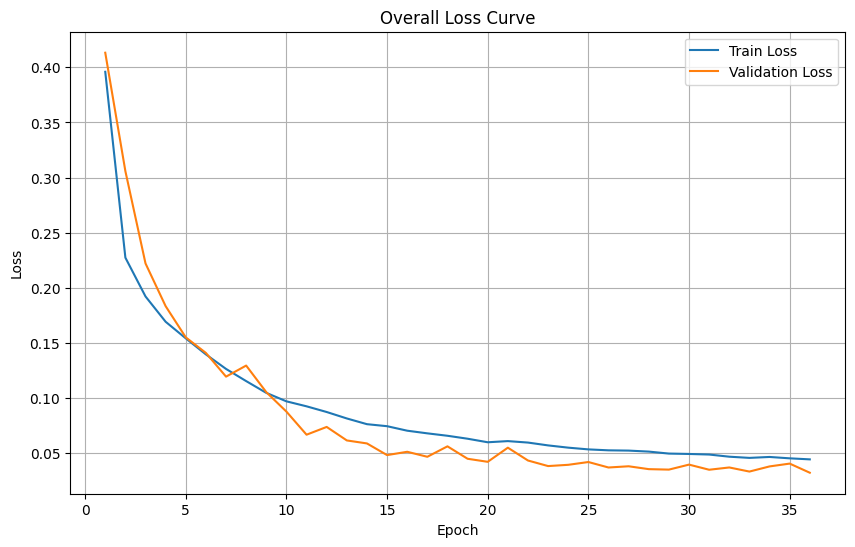

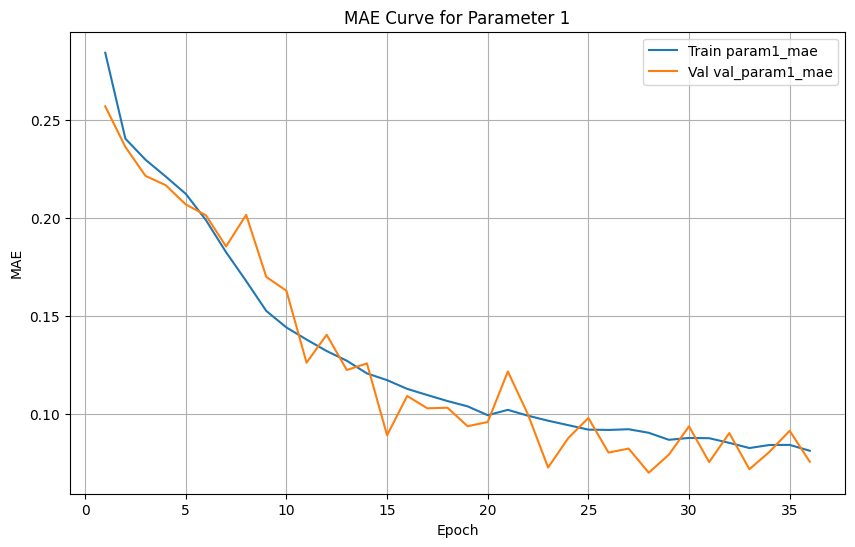

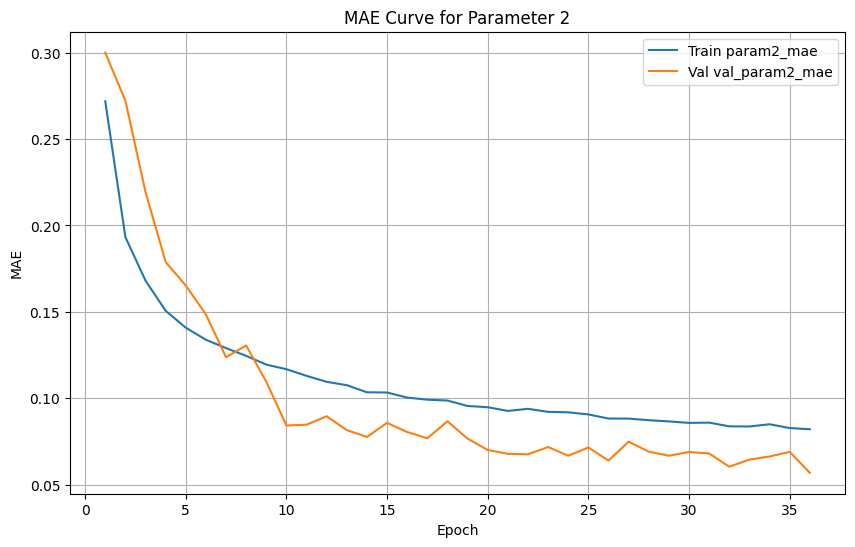

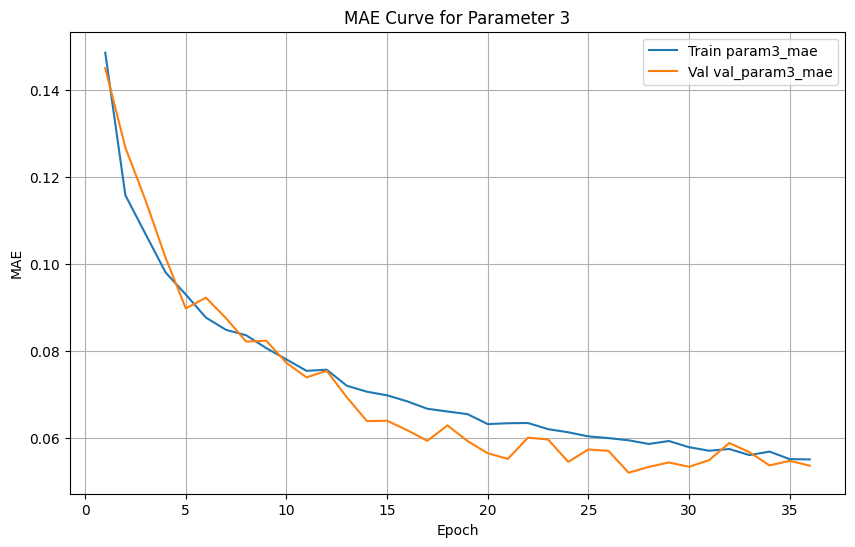

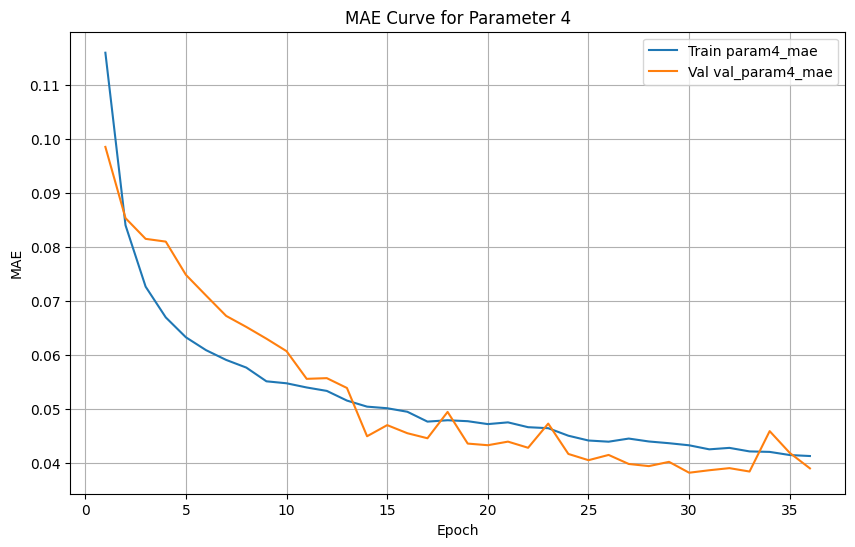

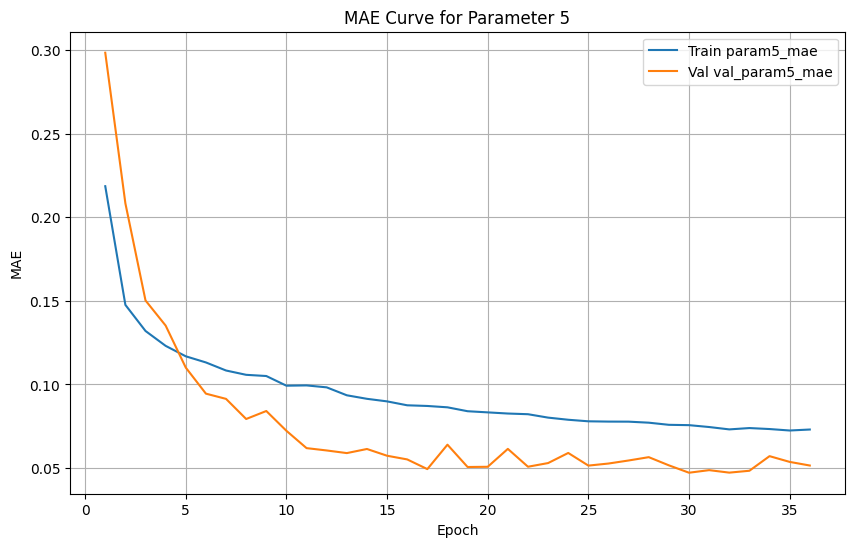

<Figure size 640x480 with 0 Axes>

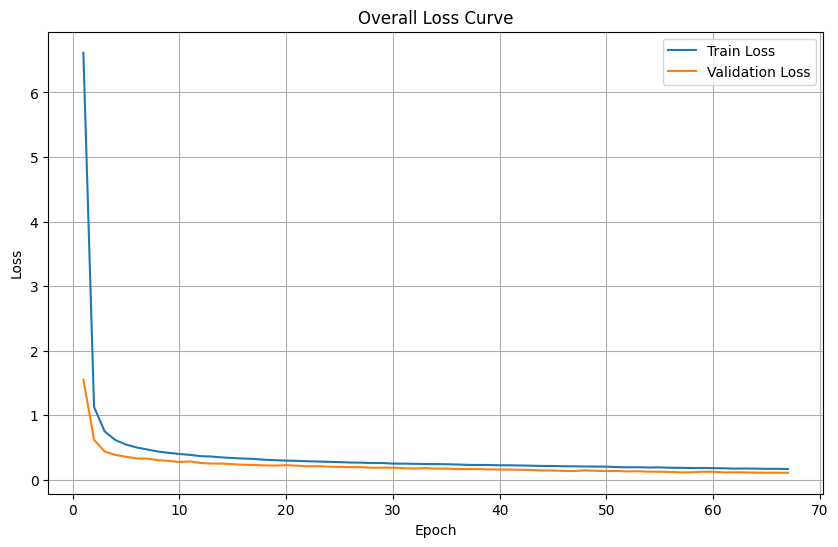

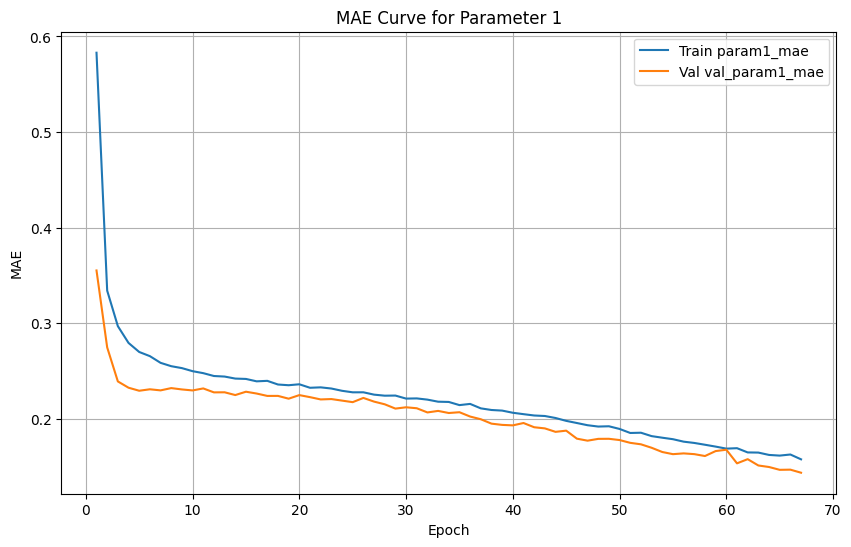

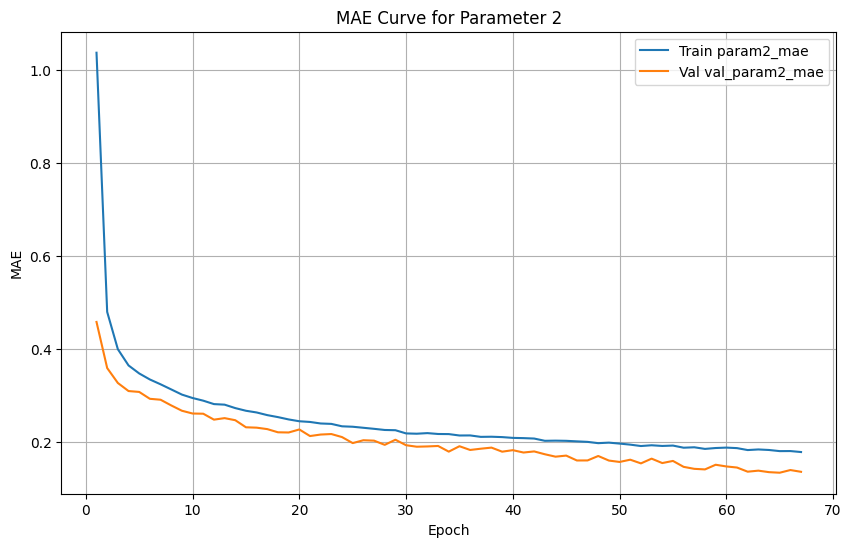

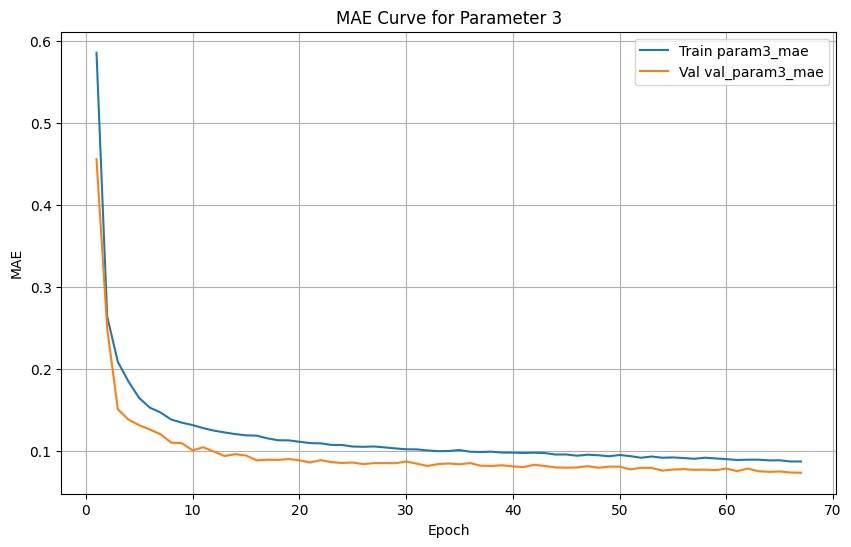

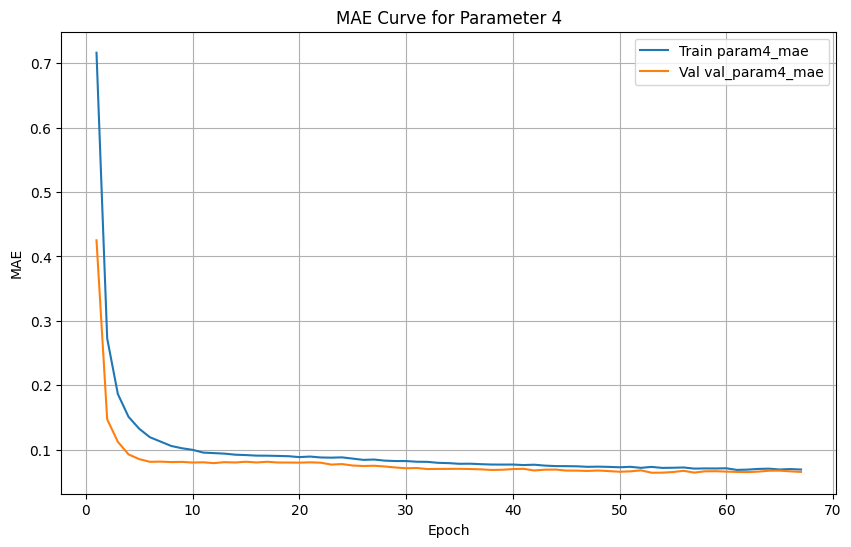

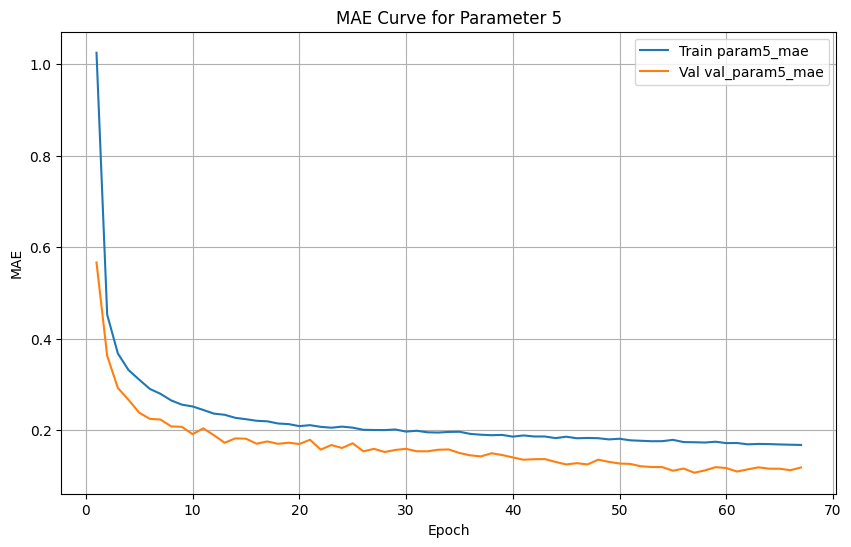

<Figure size 640x480 with 0 Axes>

In [25]:
def plot_ensemble_metrics(ensemble_histories):
    # Determine the minimum number of epochs across all histories
    min_epochs = min(len(hist['loss']) for hist in ensemble_histories.values())
    epochs = range(1, min_epochs + 1)
    
    # ---- Overall Loss ----
    train_loss_list, val_loss_list = [], []
    for hist in ensemble_histories.values():
        train_loss_list.append(np.array(hist['loss'][:min_epochs]))
        val_loss_list.append(np.array(hist['val_loss'][:min_epochs]))
    
    train_loss_arr = np.stack(train_loss_list, axis=0)
    val_loss_arr   = np.stack(val_loss_list, axis=0)
    
    avg_train_loss = np.mean(train_loss_arr, axis=0)
    avg_val_loss   = np.mean(val_loss_arr, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_loss, label='Train Loss')
    plt.plot(epochs, avg_val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Overall Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # ---- Per-Parameter MAE Curves ----
    for i in range(5):
        key = f'param{i+1}_mae'
        val_key = f'val_param{i+1}_mae'
        
        train_metric_list, val_metric_list = [], []
        for hist in ensemble_histories.values():
            train_metric_list.append(np.array(hist[key][:min_epochs]))
            val_metric_list.append(np.array(hist[val_key][:min_epochs]))
        
        train_metric_arr = np.stack(train_metric_list, axis=0)
        val_metric_arr   = np.stack(val_metric_list, axis=0)
        
        avg_train_metric = np.mean(train_metric_arr, axis=0)
        avg_val_metric   = np.mean(val_metric_arr, axis=0)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, avg_train_metric, label=f'Train {key}')
        plt.plot(epochs, avg_val_metric, label=f'Val {val_key}')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title(f'MAE Curve for Parameter {i+1}')
        plt.legend()
        plt.grid(True)
        plt.show()
    plt.tight_layout()

ensemble_histories = {f"fold{i+1}": history.history for i, history in enumerate(fold_histories)}
ensemble_histories_transformer = {f"fold{i+1}": hist.history for i, hist in enumerate(fold_histories_transformer)}
ensemble_histories_tuned = {f"fold{i+1}": history.history for i, history in enumerate(fold_histories_tuned)}
ensemble_histories_transformer_tuned = {f"fold{i+1}": hist.history for i, hist in enumerate(fold_histories_transformer_tuned)}

plot_ensemble_metrics(ensemble_histories_tuned)
plot_ensemble_metrics(ensemble_histories_transformer_tuned)


1/1 [==============================] - 0s 113ms/step


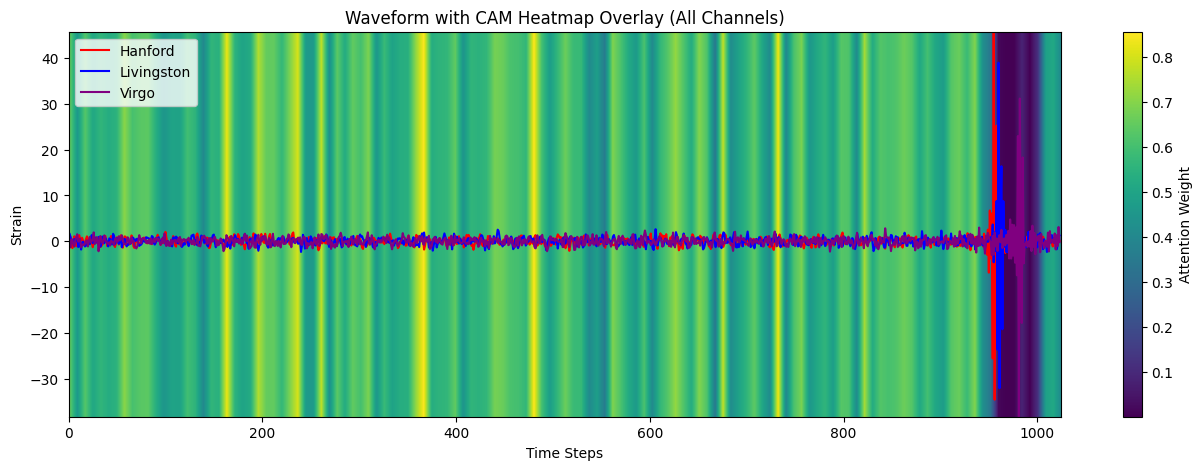

1/1 [==============================] - 0s 106ms/step


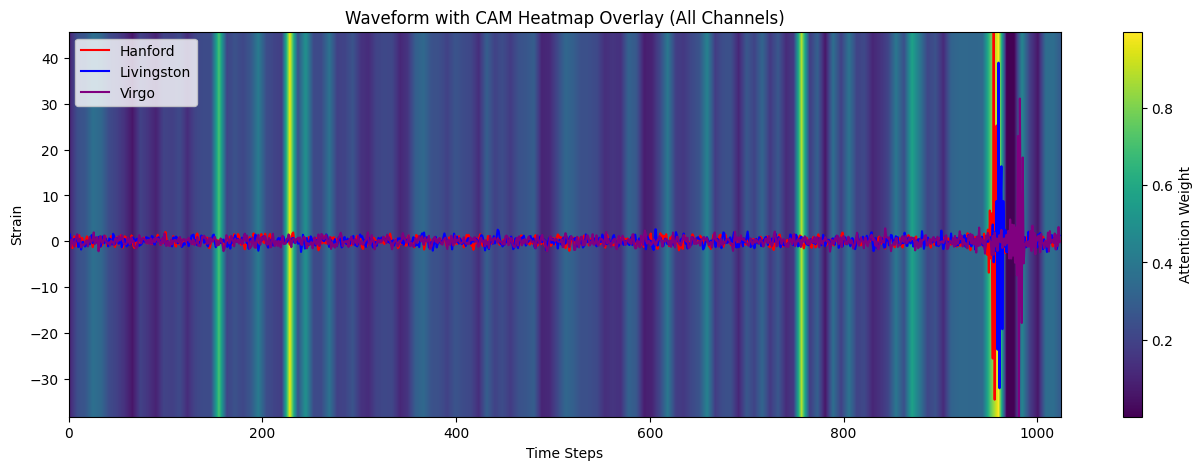

1/1 [==============================] - 0s 101ms/step


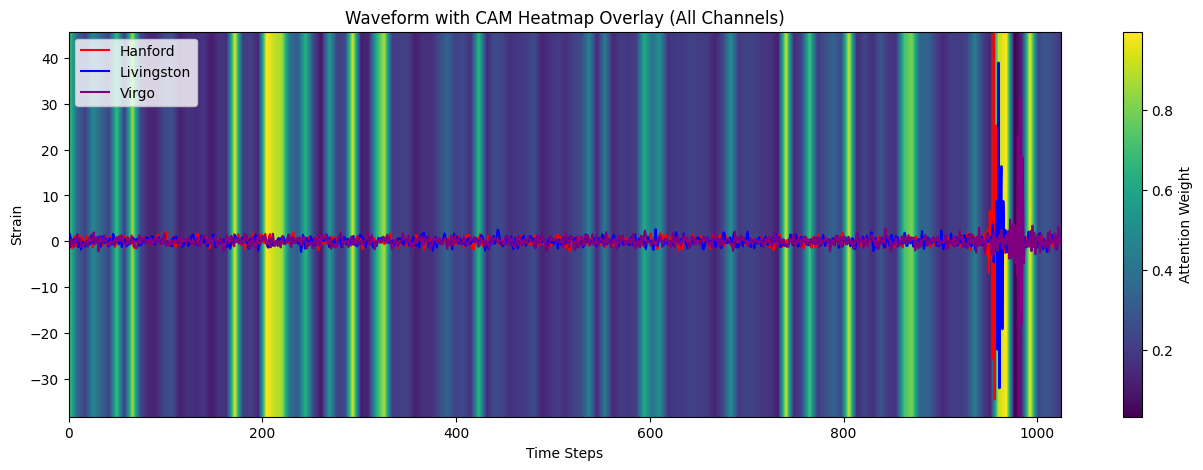

1/1 [==============================] - 0s 106ms/step


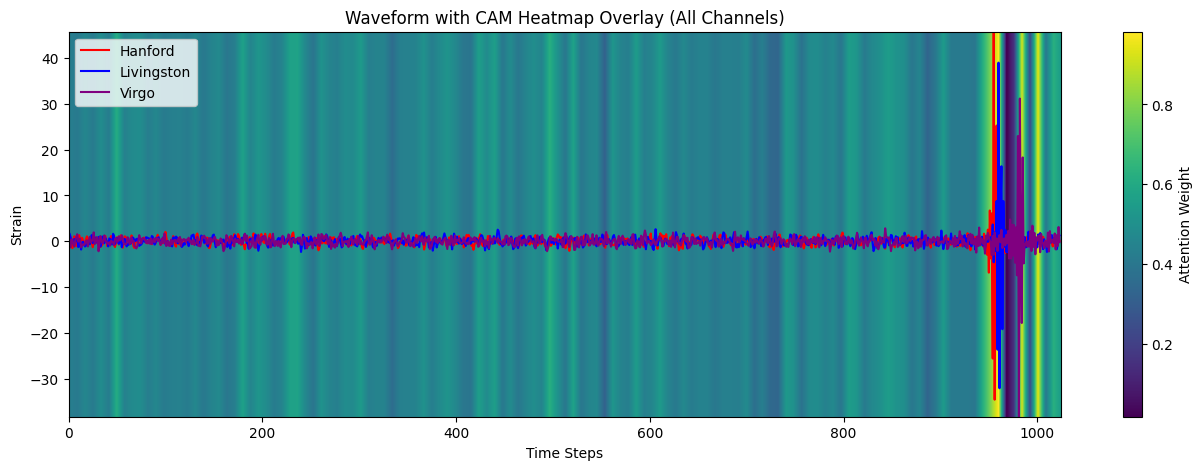

1/1 [==============================] - 0s 101ms/step


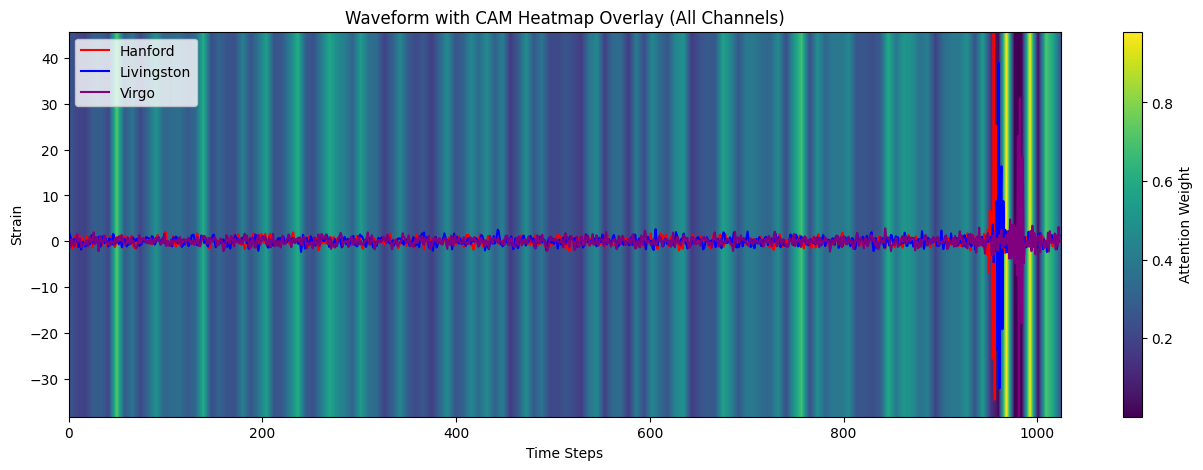

In [26]:
def visualize_cam_all_channels(sample_index, model):
    # Extract the waveform sample
    waveform_sample = X_test[sample_index]  # shape (1024, 3)

    # Determine overall min and max for y-axis across all channels
    y_min = waveform_sample.min()
    y_max = waveform_sample.max()

    # Build a model that outputs the CAM from the layer named 'cam_layer'
    cam_model = keras.Model(inputs=model.input, outputs=model.get_layer('cam_layer').output)

    # For a multi-input model, pass both inputs as a list. Here we assume corr_test is indexed similarly.
    cam_out = cam_model.predict([X_test[[sample_index]], corr_test[[sample_index]]])[0]
    cam_out = cam_out.squeeze()

    # Upsample the CAM to match the waveform length
    num_points = 1024
    x_old = np.linspace(0, num_points - 1, num=len(cam_out))
    x_new = np.arange(num_points)
    cam_upsampled = np.interp(x_new, x_old, cam_out)

    # Create a 2D heatmap array by replicating the upsampled CAM
    heatmap = np.tile(cam_upsampled, (10, 1))

    # Plot the waveform (all channels) and overlay the CAM heatmap
    fig, ax = plt.subplots(figsize=(16, 5))
    x = np.arange(num_points)
    ax.plot(x, waveform_sample[:, 0], label='Hanford', color='red')
    ax.plot(x, waveform_sample[:, 1], label='Livingston', color='blue')
    ax.plot(x, waveform_sample[:, 2], label='Virgo', color='purple')

    # Overlay the heatmap with imshow
    im = ax.imshow(heatmap, aspect='auto', cmap='viridis', alpha=1,
                   extent=[0, num_points, y_min, y_max],
                   origin='lower')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight')

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Strain')
    ax.set_title('Waveform with CAM Heatmap Overlay (All Channels)')
    ax.legend()
    plt.show()

# Example usage:
# Assume X_test and corr_test are defined and properly indexed.
indexes = np.random.randint(0, 300, 1)
for i in indexes:
    visualize_cam_all_channels(sample_index=i, model=model_v1)
    visualize_cam_all_channels(sample_index=i, model=model_v2)
    visualize_cam_all_channels(sample_index=i, model=model_v3)
    visualize_cam_all_channels(sample_index=i, model=best_model)
    visualize_cam_all_channels(sample_index=i, model=best_model_2)

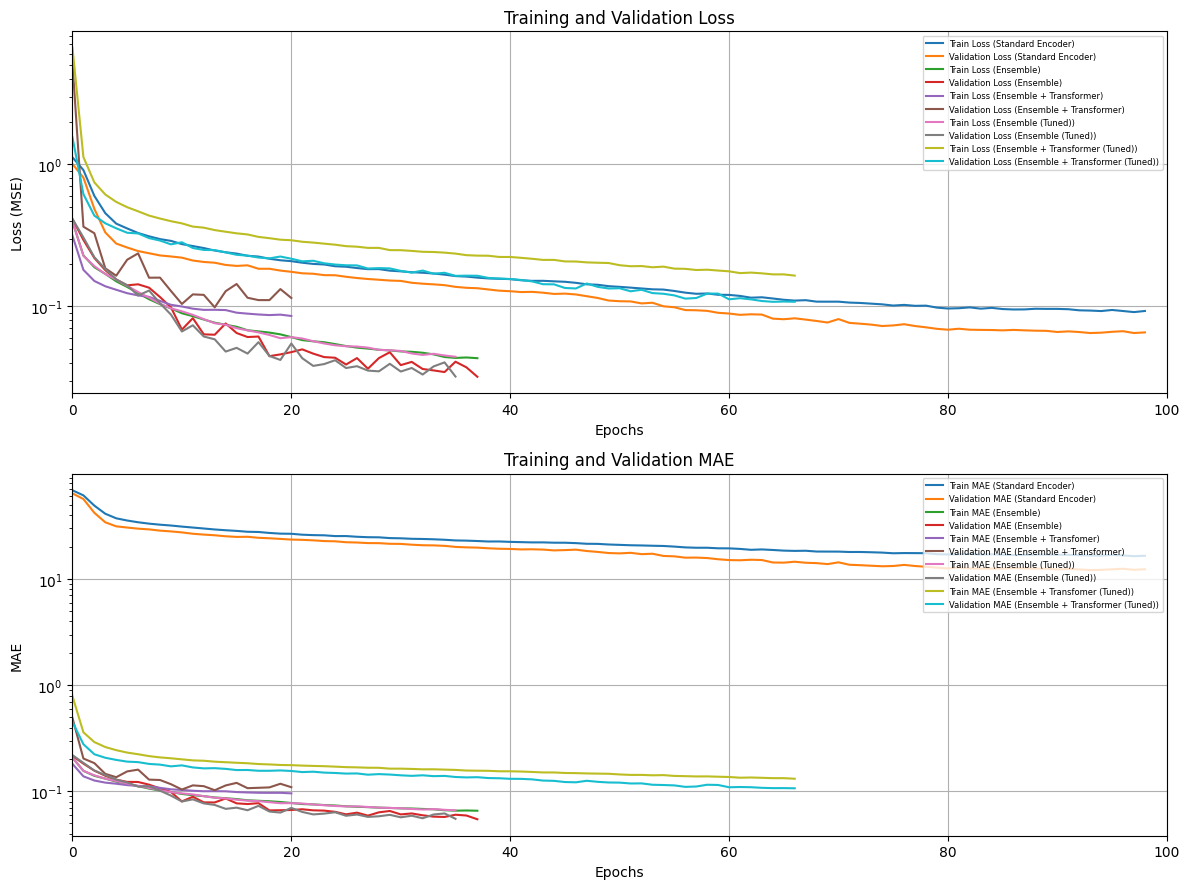

In [27]:
def compute_total_stats(history, target_scaler):
    # Keys for training and validation metrics (assume each history entry is in normalized space)
    train_keys_mae = [f'param{i}_mae' for i in range(1, 6)]
    val_keys_mae   = [f'val_param{i}_mae' for i in range(1, 6)]
    train_keys_r2  = [f'param{i}_R2Score' for i in range(1, 6)]
    val_keys_r2    = [f'val_param{i}_R2Score' for i in range(1, 6)]
    
    # Determine minimum epochs for consistency.
    min_epochs = len(history['loss'])
    
    # Function to inverse-scale metric values.
    def inverse_metric(metric_values):
        metric_array = np.array(metric_values)
        scale_range = target_scaler.data_max_ - target_scaler.data_min_
        return metric_array * scale_range.mean()
    
    total_train_mae = np.mean([inverse_metric(history[k]) for k in train_keys_mae if k in history], axis=0)
    total_val_mae   = np.mean([inverse_metric(history[k]) for k in val_keys_mae if k in history], axis=0)
    
    # For R2Score, if key is missing, substitute zeros.
    def get_metric(hist, key):
        if key in hist:
            return np.array(hist[key])
        else:
            return np.zeros(min_epochs)
    
    total_train_r2 = np.mean([get_metric(history, k) for k in train_keys_r2], axis=0)
    total_val_r2   = np.mean([get_metric(history, k) for k in val_keys_r2], axis=0)
    
    return total_train_mae, total_val_mae, total_train_r2, total_val_r2
    
total_train_mae_v1, total_val_mae_v1, total_train_r2_v1, total_val_r2_v1 = compute_total_stats(history_model_v1.history, scaler)

def compute_ensemble_stats(ensemble_histories):
    # Determine the minimum number of epochs across all fold histories
    min_epochs = min(len(hist['loss']) for hist in ensemble_histories.values())
    
    # Initialize lists for overall loss (as lists, not dictionaries)
    train_loss_list, val_loss_list = [], []
    
    # Initialize dictionaries for MAE for each parameter.
    train_mae_dict = {f'param{i+1}': [] for i in range(5)}
    val_mae_dict   = {f'param{i+1}': [] for i in range(5)}
    
    for hist in ensemble_histories.values():
        # Overall loss (the total loss is recorded under 'loss')
        train_loss_list.append(np.array(hist['loss'][:min_epochs]))
        if 'val_loss' in hist:
            val_loss_list.append(np.array(hist['val_loss'][:min_epochs]))
        # For each output, collect the corresponding MAE metrics.
        for i in range(5):
            key = f'param{i+1}_mae'
            val_key = f'val_param{i+1}_mae'
            train_mae_dict[f'param{i+1}'].append(np.array(hist[key][:min_epochs]))
            val_mae_dict[f'param{i+1}'].append(np.array(hist[val_key][:min_epochs]))
    
    # Stack overall losses into arrays of shape (num_folds, min_epochs)
    train_loss_arr = np.stack(train_loss_list, axis=0)
    avg_train_loss = np.mean(train_loss_arr, axis=0)
    
    if val_loss_list:  # if validation losses are recorded
        val_loss_arr = np.stack(val_loss_list, axis=0)
        avg_val_loss = np.mean(val_loss_arr, axis=0)
    else:
        avg_val_loss = None
    
    # For each output, stack and average the MAE values over folds.
    avg_train_mae = {}
    avg_val_mae   = {}
    for i in range(5):
        param = f'param{i+1}'
        train_arr = np.stack(train_mae_dict[param], axis=0)
        avg_train_mae[param] = np.mean(train_arr, axis=0)
        val_arr = np.stack(val_mae_dict[param], axis=0)
        avg_val_mae[param] = np.mean(val_arr, axis=0)
    
    return avg_train_loss, avg_val_loss, avg_train_mae, avg_val_mae


ensemble_train_loss, ensemble_val_loss, ensemble_train_mae, ensemble_val_mae = compute_ensemble_stats(ensemble_histories)
ensemble_train_loss_t, ensemble_val_loss_t, ensemble_train_mae_t, ensemble_val_mae_t = compute_ensemble_stats(ensemble_histories_transformer)
ensemble_train_loss_tuned, ensemble_val_loss_tuned, ensemble_train_mae_tuned, ensemble_val_mae_tuned = compute_ensemble_stats(ensemble_histories_tuned)
ensemble_train_loss_t_tuned, ensemble_val_loss_t_tuned, ensemble_train_mae_t_tuned, ensemble_val_mae_t_tuned = compute_ensemble_stats(ensemble_histories_transformer_tuned)

# Plotting Graphs
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Loss Curve (Training vs Validation)
axes[0].plot(history_model_v1.history['loss'], label='Train Loss (Standard Encoder)')
axes[0].plot(history_model_v1.history['val_loss'], label='Validation Loss (Standard Encoder)')
axes[0].plot(ensemble_train_loss, label='Train Loss (Ensemble)')
axes[0].plot(ensemble_val_loss, label='Validation Loss (Ensemble)')
axes[0].plot(ensemble_train_loss_t, label='Train Loss (Ensemble + Transformer)')
axes[0].plot(ensemble_val_loss_t, label='Validation Loss (Ensemble + Transformer)')
axes[0].plot(ensemble_train_loss_tuned, label='Train Loss (Ensemble (Tuned))')
axes[0].plot(ensemble_val_loss_tuned, label='Validation Loss (Ensemble (Tuned))')
axes[0].plot(ensemble_train_loss_t_tuned, label='Train Loss (Ensemble + Transformer (Tuned))')
axes[0].plot(ensemble_val_loss_t_tuned, label='Validation Loss (Ensemble + Transformer (Tuned))')
axes[0].set_xlim([0, 100])
axes[0].set_yscale('log')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend(loc=1, prop={'size': 6})
axes[0].grid(True)

# Mean Absolute Error Curve (Aggregate)
# For the ensemble, average MAE across outputs:
ensemble_train_mae_avg = np.mean([avg for avg in ensemble_train_mae.values()], axis=0)
ensemble_val_mae_avg = np.mean([avg for avg in ensemble_val_mae.values()], axis=0)
ensemble_train_mae_avg_t = np.mean([avg for avg in ensemble_train_mae_t.values()], axis=0)
ensemble_val_mae_avg_t = np.mean([avg for avg in ensemble_val_mae_t.values()], axis=0)
ensemble_train_mae_avg_tuned = np.mean([avg for avg in ensemble_train_mae_tuned.values()], axis=0)
ensemble_val_mae_avg_tuned = np.mean([avg for avg in ensemble_val_mae_tuned.values()], axis=0)
ensemble_train_mae_avg_t_tuned = np.mean([avg for avg in ensemble_train_mae_t_tuned.values()], axis=0)
ensemble_val_mae_avg_t_tuned = np.mean([avg for avg in ensemble_val_mae_t_tuned.values()], axis=0)
axes[1].plot(total_train_mae_v1, label='Train MAE (Standard Encoder)')
axes[1].plot(total_val_mae_v1, label='Validation MAE (Standard Encoder)')
axes[1].plot(ensemble_train_mae_avg, label='Train MAE (Ensemble)')
axes[1].plot(ensemble_val_mae_avg, label='Validation MAE (Ensemble)')
axes[1].plot(ensemble_train_mae_avg_t, label='Train MAE (Ensemble + Transfomer)')
axes[1].plot(ensemble_val_mae_avg_t, label='Validation MAE (Ensemble + Transformer)')
axes[1].plot(ensemble_train_mae_avg_tuned, label='Train MAE (Ensemble (Tuned))')
axes[1].plot(ensemble_val_mae_avg_tuned, label='Validation MAE (Ensemble (Tuned))')
axes[1].plot(ensemble_train_mae_avg_t_tuned, label='Train MAE (Ensemble + Transfomer (Tuned))')
axes[1].plot(ensemble_val_mae_avg_t_tuned, label='Validation MAE (Ensemble + Transformer (Tuned))')
axes[1].set_yscale('log')
axes[1].set_xlim([0, 100])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend(loc=1, prop={'size': 6})
axes[1].grid(True)

plt.tight_layout()
plt.show()

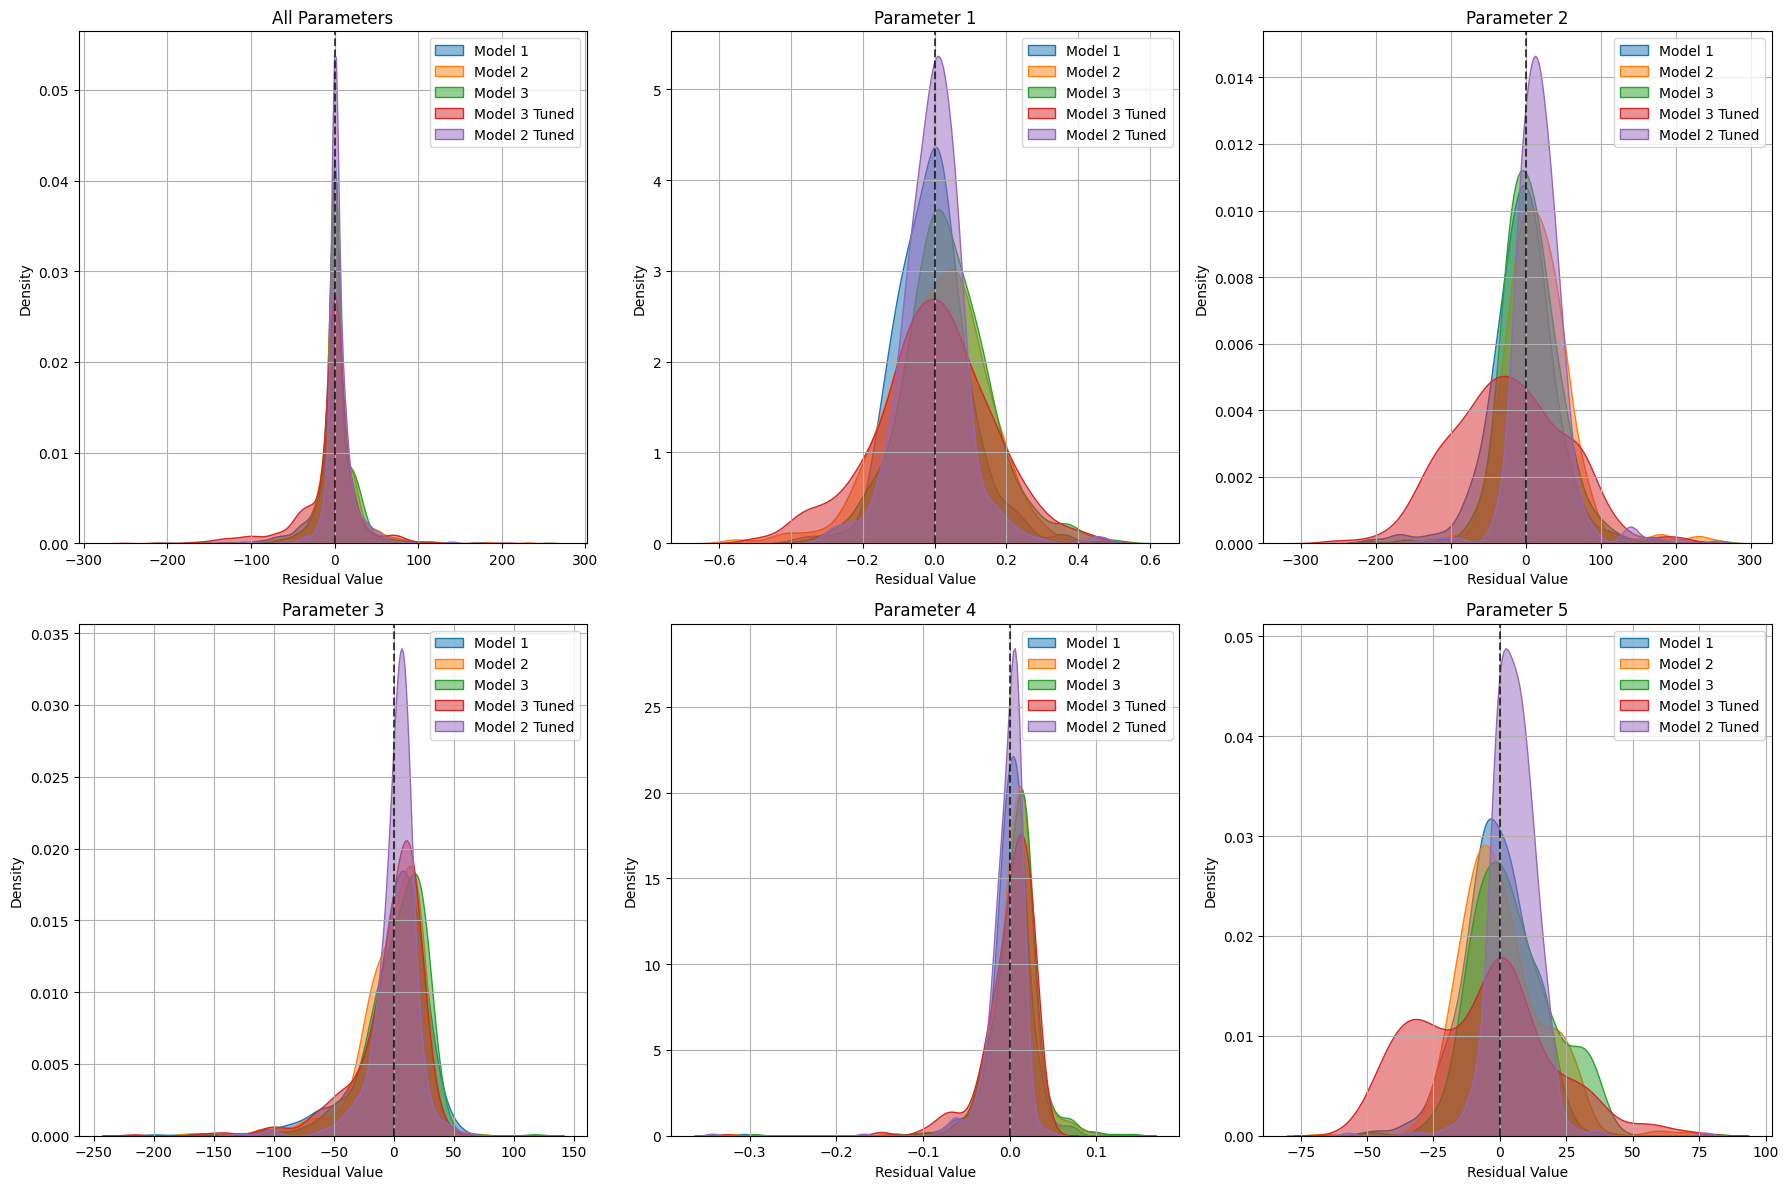

In [28]:
import seaborn as sns

def predict_params_unscaled(model, sample, scaler):
    # Ensure the sample has a batch dimension: from (1024, 3) to (1, 1024, 3)
    sample_batch = np.expand_dims(sample, axis=0)
    
    # Compute Pearson correlations
    stat1 = pg.corr(sample[:, 0], sample[:, 1])
    stat2 = pg.corr(sample[:, 0], sample[:, 2])
    stat3 = pg.corr(sample[:, 1], sample[:, 2])
    
    # Create the correlation stats input with a batch dimension
    corr_stats = np.array([[stat1.r, stat2.r, stat3.r]])
    
    # Predict using the model.
    y_pred_list = model.predict([sample_batch, corr_stats], verbose=0)
    
    # Convert the list of arrays to a 1D array of 5 values.
    y_pred_scaled = np.array([pred[0, 0] for pred in y_pred_list])
    
    y_pred_scaled = y_pred_scaled.reshape(1, -1)
    y_pred_original = scaler.inverse_transform(y_pred_scaled).flatten()
    
    return y_pred_original

def compute_residuals(models, X, y_true, scaler):
    residuals = [np.array([predict_params_unscaled(model, sample, scaler) for sample in X]) - y_true for model in models]
    return residuals

def plot_residual_distributions(residuals, model_labels):
    num_params = residuals[0].shape[1]  # Number of target variables
    param_labels = [f'Parameter {i+1}' for i in range(num_params)]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Plot distributions
    for i in range(num_params + 1):  # +1 for combined plot
        ax = axes[i]
        for res, label in zip(residuals, model_labels):
            data = res.flatten() if i == 0 else res[:, i-1]
            sns.kdeplot(data, ax=ax, label=label, fill=True, alpha=0.5)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.7)
        ax.set_xlabel("Residual Value")
        ax.set_ylabel("Density")
        ax.set_title("All Parameters" if i == 0 else param_labels[i-1])
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

models = [model_v1, model_v2, model_v3, best_model, best_model_2]  # List of trained models
residuals = compute_residuals(models, X_test, y_test, scaler)
plot_residual_distributions(residuals, ["Model 1", "Model 2", "Model 3", "Model 3 Tuned", "Model 2 Tuned"])